# Food-101: Prediciendo platos de comida

<img src="food-101.jpg" />

# Dependencias

Vamos a estar usando las mismas dependencias que para el notebook de "profes_classifier":

    pip install pillow scikit-learn pandas matplotlib tensorflow h5py sh jupyter tensorflow-datasets

# Datos

Los datos se pueden descargar desde [este link](http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz).

Por simplicidad y rapidez, en este ejemplo en lugar de utilizar las 101 categorías nos vamos a concentrar en un subconjunto de 7. Se puede replicar esto mismo cancelando la descarga antes de que finalice. 

Después de descargar los datos, se debería modificar la estructura de los mismos para lograr algo semejante a lo que se muestra a continuación.

In [1]:
!tree food-7 -d

food-7
├── test
│   ├── beignets
│   ├── bruschetta
│   ├── chicken_wings
│   ├── hamburger
│   ├── pork_chop
│   ├── prime_rib
│   └── ramen
└── train
    ├── beignets
    ├── bruschetta
    ├── chicken_wings
    ├── hamburger
    ├── pork_chop
    ├── prime_rib
    └── ramen

16 directories


# Imports y configs

In [2]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

# esto es necesario si cancelaron la descarga, para que no genere una excepción al intentar leer imágenes rotas.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Variables generales para definir cómo vamos a trabajar

In [3]:
# etiquetas posibles
COMIDAS = "beignets", "bruschetta", "chicken_wings", "hamburger", "pork_chop", "prime_rib", "ramen"

# configuraciones comúnes a utilizar para leer los datos
TRAIN_DIR = Path('./food-7/train')
VALIDATION_DIR = Path('./food-7/test')
SIZE = (150, 150)
COLOR = "rgb"
SEED = 42

PARAMETROS_COMUNES_DATASET = dict(
    class_mode="categorical",
    classes=COMIDAS,
    target_size=SIZE, 
    color_mode=COLOR, 
)

# Generando los conjuntos de datos

In [4]:
train_generator = ImageDataGenerator(rescale=1/255)
train = train_generator.flow_from_directory(TRAIN_DIR, **PARAMETROS_COMUNES_DATASET)

validation_generator = ImageDataGenerator(rescale=1./255)
validation = validation_generator.flow_from_directory(
    VALIDATION_DIR,
    batch_size=869,  # leer todas las imagenes de una sola vez
    **PARAMETROS_COMUNES_DATASET,
)

Found 5420 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.


In [5]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(COMIDAS[np.argmax(labels[i])])
        plt.axis("off")

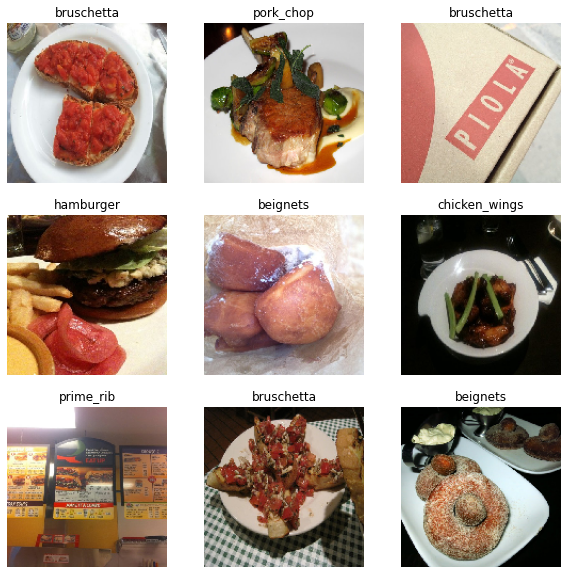

In [6]:
sample_images(train)

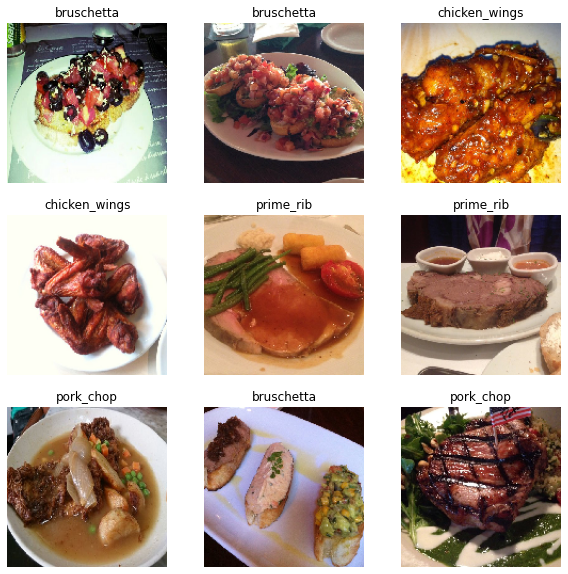

In [7]:
sample_images(validation)

# Probamos usar una arquitectura simple (misma estructura que usamos en el clasificador de profes)

In [8]:
model = Sequential([
    Convolution2D(input_shape=(150, 150, 3), filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.2),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    Dense(10, activation='tanh'),
    Dropout(0.2),
    Dense(10, activation='tanh'),
    Dropout(0.2),
    Dense(len(COMIDAS), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 147, 147, 8)       392       
_________________________________________________________________
dropout (Dropout)            (None, 147, 147, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 144, 8)       1032      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 144, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

In [10]:
history = model.fit(
    train,
    epochs=10,
    batch_size=128,
    validation_data=validation,
)

Epoch 1/10
170/170 [==============================] - 60s 348ms/step - loss: 1.8699 - accuracy: 0.2493 - val_loss: 1.7414 - val_accuracy: 0.3436
Epoch 2/10
170/170 [==============================] - 54s 318ms/step - loss: 1.6770 - accuracy: 0.3651 - val_loss: 1.7171 - val_accuracy: 0.3486
Epoch 3/10
170/170 [==============================] - 49s 289ms/step - loss: 1.5754 - accuracy: 0.4251 - val_loss: 1.6437 - val_accuracy: 0.3914
Epoch 4/10
170/170 [==============================] - 47s 278ms/step - loss: 1.4867 - accuracy: 0.4614 - val_loss: 1.6292 - val_accuracy: 0.3729
Epoch 5/10
170/170 [==============================] - 47s 277ms/step - loss: 1.3956 - accuracy: 0.5000 - val_loss: 1.6119 - val_accuracy: 0.3879
Epoch 6/10
170/170 [==============================] - 47s 274ms/step - loss: 1.3205 - accuracy: 0.5310 - val_loss: 1.5999 - val_accuracy: 0.3950
Epoch 7/10
170/170 [==============================] - 46s 267ms/step - loss: 1.2224 - accuracy: 0.5731 - val_loss: 1.6909 - val_ac

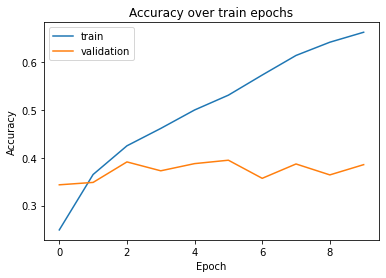

In [11]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Qué pasa si probamos con una red pre-entrenada? Por ejemplo, VGG16

<img src='https://storage.googleapis.com/lds-media/images/vgg16-architecture.width-1200.jpg' />

In [5]:
## obtenemos la red pre-entrenada (la primera vez va a descargar los pesos)

# descomentar si obtienen un error al intentar descargar los pesos
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

base_model = VGG16(weights="imagenet", 
                   # Remove last layer.
                   include_top=False, 
                   input_shape=(150, 150, 3))

base_model.trainable = False ## freezamos los pesos de la red

In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [7]:
model = Sequential([
    base_model,
    Flatten(),   
    Dense(50, activation='relu'),   
    Dense(20, activation='relu'),
    Dense(len(COMIDAS), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [8]:
history = model.fit(train, 
                    batch_size=560,
                    epochs=10,
                    validation_data=validation)

Epoch 1/10
170/170 [==============================] - 439s 3s/step - loss: 1.3548 - accuracy: 0.4934 - val_loss: 1.0839 - val_accuracy: 0.6129
Epoch 2/10
170/170 [==============================] - 402s 2s/step - loss: 0.8472 - accuracy: 0.7020 - val_loss: 0.9592 - val_accuracy: 0.6557
Epoch 3/10
170/170 [==============================] - 395s 2s/step - loss: 0.6377 - accuracy: 0.7814 - val_loss: 1.0291 - val_accuracy: 0.6450
Epoch 4/10
170/170 [==============================] - 397s 2s/step - loss: 0.4978 - accuracy: 0.8286 - val_loss: 1.0059 - val_accuracy: 0.6536
Epoch 5/10
170/170 [==============================] - 406s 2s/step - loss: 0.3653 - accuracy: 0.8838 - val_loss: 1.0454 - val_accuracy: 0.6614
Epoch 6/10
170/170 [==============================] - 397s 2s/step - loss: 0.2534 - accuracy: 0.9247 - val_loss: 1.1649 - val_accuracy: 0.6500
Epoch 7/10
170/170 [==============================] - 397s 2s/step - loss: 0.1944 - accuracy: 0.9450 - val_loss: 1.1448 - val_accuracy: 0.6679

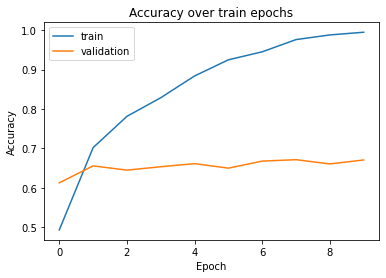

In [9]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()